Name; Lalitha Krishnamurthy

PART 1

• DOMAIN: Entertainment
• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. 
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the 
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision 
and multimedia experts who need to detect faces from screen shots from the movie scene.
• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
• PROJECT OBJECTIVE: Face detection from training images.
Steps and tasks: [ Total Score: points]
1. Import the dataset.
2. Create features (images) and labels (mask) using that data.
3. Mask detection model:
● Design a face mask detection model. 
 Hint: Use U-net along with pre-trained transfer learning models
● Design your own Dice Coe"icient and Loss function. 
● Train, tune and test the model.
● Evaluate the model using testing data.
4. Use the “Prediction image” as an input to your designed model and display the output of the image

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

**1.Import the dataset.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Computer_Vision/Week6/')

In [ ]:
data = np.load('images.npy',allow_pickle=True)

In [ ]:
print('Shape of the dataset',data.shape)

In [ ]:
#Multidimensional array with 1 dimension as image
a = data[1,0]

In [ ]:
a.shape

(697, 1280, 4)

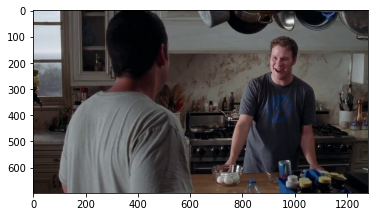

In [ ]:
plt.imshow(a)
plt.show()

In [ ]:
print('Viewing the second dimenion of the first image printed')
data[1,1]


Viewing the second dimenion of the first image printed


[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}]}]

**2. Create features (images) and labels (mask) using that data.**

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [ ]:
masks=np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH)) ##creating a array of size image_width and image hieght with zero
x_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3)) ##creating a array of size image_width and image hieght with zero
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))#, #interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    x_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
print('Shape of X_train: ', x_train.shape)
print('Shape of mask array: ', masks.shape)

Shape of X_train:  (409, 224, 224, 3)
Shape of mask array:  (409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.62352943  0.69411767  0.78039217]
  [ 0.62352943  0.69411767  0.78039217]
  [ 0.60000002  0.68627453  0.78039217]
  ...
  [-0.73333335 -0.74901962 -0.74117649]
  [-0.73333335 -0.74901962 -0.74117649]
  [-0.73333335 -0.74901962 -0.74117649]]

 [[ 0.62352943  0.69411767  0.78039217]
  [ 0.6156863   0.69411767  0.78039217]
  [ 0.60784316  0.69411767  0.77254903]
  ...
  [-0.74117649 -0.74901962 -0.74117649]
  [-0.72549021 -0.74117649 -0.73333335]
  [-0.72549021 -0.74117649 -0.73333335]]

 [[ 0.6156863   0.69411767  0.78039217]
  [ 0.6156863   0.69411767  0.78039217]
  [ 0.60784316  0.69411767  0.78039217]
  ...
  [-0.74117649 -0.74901962 -0.74901962]
  [-0.71764708 -0.73333335 -0.72549021]
  [-0.73333335 -0.74117649 -0.73333335]]

 ...

 [[-0.74901962 -0.81960785 -0.8509804 ]
  [-0.73333335 -0.80392158 -0.83529413]
  [-0.71764708 -0.78823531 -0.82745099]
  ...
  [-1.         -0.99215686 -0.96862745]
  [-1.         -0.99215686 -0.96862745]
  [-1.         -0.99215686 -0.96862745]]

 [

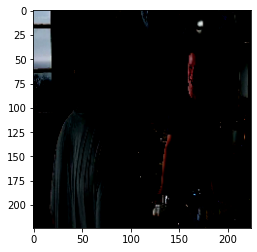

In [ ]:
from matplotlib import pyplot
n = 1
print(x_train[n])
pyplot.imshow(x_train[n])

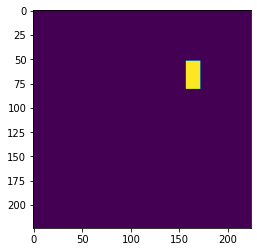

In [ ]:
pyplot.imshow(masks[n])

**3. Mask detection model**

● Design a face mask detection model. Hint: Use U-net along with pre-trained transfer learning models

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

In [ ]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

ALPHA = 1

In [ ]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output 
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    #block3 = model.get_layer("conv_pw_11_relu").output
    #block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block2), block1])
    #x = Concatenate()([UpSampling2D()(x), block2])
    #x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [ ]:
model = create_model(False)
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                           

**● Design your own Dice Coe"icient and Loss function.**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

**● Train, tune and test the model**

In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

**Define Checkpoint and early stopping**

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/Computer_Vision/Week6/modelsaved.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)
stop = EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

**● Evaluate the model using testing data**

In [ ]:
EPOCHS = 20
BATCH_SIZE = 1
THREADS = 5

In [ ]:
model.fit(x=x_train, y=masks, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[checkpoint,reduce_lr, stop], validation_split=0.2, workers=THREADS, use_multiprocessing=True)


Epoch 1/20
324/327 [============================>.] - ETA: 0s - loss: 2.5916 - dice_coefficient: 0.1770
Epoch 1: val_loss improved from inf to 2.30036, saving model to /content/drive/My Drive/Computer_Vision/Week6/modelsaved.h5
327/327 [==============================] - 11s 22ms/step - loss: 2.5854 - dice_coefficient: 0.1777 - val_loss: 2.3004 - val_dice_coefficient: 0.1946 - lr: 1.0000e-04
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 2.2212 - dice_coefficient: 0.2087
Epoch 2: val_loss improved from 2.30036 to 2.04286, saving model to /content/drive/My Drive/Computer_Vision/Week6/modelsaved.h5
327/327 [==============================] - 6s 17ms/step - loss: 2.2212 - dice_coefficient: 0.2087 - val_loss: 2.0429 - val_dice_coefficient: 0.2218 - lr: 1.0000e-04
Epoch 3/20
324/327 [============================>.] - ETA: 0s - loss: 2.0248 - dice_coefficient: 0.2351
Epoch 3: val_loss improved from 2.04286 to 1.89335, saving model to /content/drive/My Drive/Computer_Visi

In the above mode data was split into train and validation using 90/10 ratio. Best loss I got is 1.4712 and dice_coefficient of 0.3645 on the training data with just 20 epochs. The model is not so efficient

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


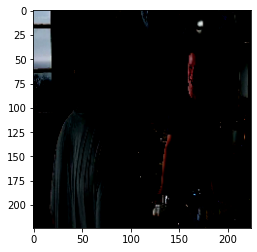

In [ ]:
n = 1
sample_image = x_train[n]
final_image = sample_image
pyplot.imshow(sample_image)

In [ ]:
sample_image.shape

(224, 224, 3)

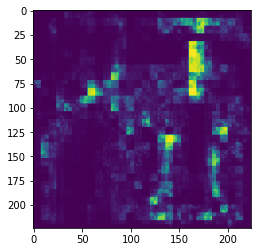

In [ ]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x=sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
pyplot.imshow(pred_mask)

Observation: The face prediction is not precise.Further i have added lower 2 layer to tune the model

In [ ]:
def create_model1(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output 
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [ ]:
model1 = create_model1()
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [ ]:
model1.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
model1.fit(x=x_train, y=masks, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[checkpoint,reduce_lr, stop], validation_split=0.2, workers=THREADS, use_multiprocessing=True)

Epoch 1/20
327/327 [==============================] - ETA: 0s - loss: 1.2438 - dice_coefficient: 0.4955
Epoch 1: val_loss improved from 1.46836 to 1.08578, saving model to /content/drive/My Drive/Computer_Vision/Week6/modelsaved.h5
327/327 [==============================] - 44s 123ms/step - loss: 1.2438 - dice_coefficient: 0.4955 - val_loss: 1.0858 - val_dice_coefficient: 0.5065 - lr: 1.0000e-04
Epoch 2/20
327/327 [==============================] - ETA: 0s - loss: 0.7624 - dice_coefficient: 0.6296
Epoch 2: val_loss improved from 1.08578 to 0.98087, saving model to /content/drive/My Drive/Computer_Vision/Week6/modelsaved.h5
327/327 [==============================] - 38s 115ms/step - loss: 0.7624 - dice_coefficient: 0.6296 - val_loss: 0.9809 - val_dice_coefficient: 0.5260 - lr: 1.0000e-04
Epoch 3/20
327/327 [==============================] - ETA: 0s - loss: 0.5704 - dice_coefficient: 0.7033
Epoch 3: val_loss improved from 0.98087 to 0.94998, saving model to /content/drive/My Drive/Comput

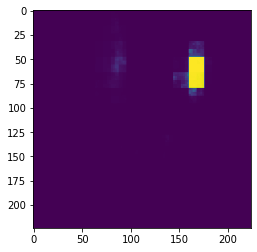

In [ ]:
pred_mask1 = model1.predict(x=sample_image)
pred_mask1 = np.resize(pred_mask1, (224, 224))
pyplot.imshow(pred_mask1)

**Use the “Prediction image” as an input to your designed model and display the output of the image**

(500, 500, 3)


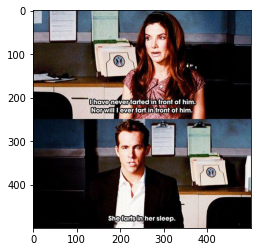

In [ ]:
import cv2 as cv
img_pred = plt.imread('/content/drive/My Drive/Computer_Vision/Week6/Part_1_Test_DataPrediction_Image.jpeg')
plt.imshow(img_pred)
print(img_pred.shape)

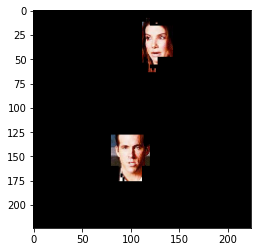

In [ ]:
img_pred1 = cv2.resize(img_pred, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(img_pred1, dtype=np.float32))
pred_mask = cv2.resize(1.0*(model1.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))
#pred_mask1 = model.predict(x=img_pred1)
image2 = img_pred1
image2[:,:,0] = pred_mask*img_pred1[:,:,0]
image2[:,:,1] = pred_mask*img_pred1[:,:,1]
image2[:,:,2] = pred_mask*img_pred1[:,:,2]
out_image = image2

plt.imshow(out_image)

Conclusion

Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics. Model checkpoint, early stopping and learning rate reducers were used as callbacks.
Data was split into train and validation using 90/10 ratio. Best loss I got is 0.33 and dice_coefficient of 0.81 on the training data with just 20 epochs.
Further checked on sample image and imposed mask on the image. As seen in the above images, it can be seen that model does a very good job in predicting the masks.

**PART B**

![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change current working directory to project folder. [ Score: 2 points ]

In [ ]:
import os
os.chdir('/content/drive/My Drive/Computer_Vision/Week6/')

#### Extract the zip file [ Score: 2 points ]
- Extract Aligned Face Dataset from Pinterest.zip

In [ ]:
zip_path = 'pinterest.zip'
from zipfile import ZipFile

with ZipFile(zip_path, 'r') as z:
  z.extractall()
print("Training zip extraction done!")



Training zip extraction done!


### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [ ]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

#metadata = load_metadata('zip_path')
metadata = load_metadata('PINS')


### Define function to load image
- Define a function to load image from the metadata

In [ ]:
import cv2
import matplotlib.pyplot as plt
def load_image(path):
    print(path)
    img = cv2.imread(path,1)
    #plt.imshow(img)
    #return 0
    # OpenCV loads images with color channels
  # in BGR order. So we need to reverse them
    return (img[...,::-1])


#### Load a sample image [ Score: 2 points ]
- Load one image using the function "load_image"

PINS/pins_margot robbie face/margot robbie face62.jpg


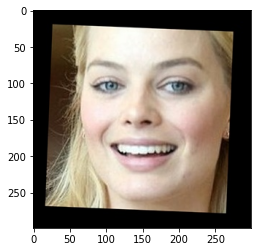

In [ ]:
l='PINS/pins_margot robbie face/margot robbie face62.jpg'
image1=load_image(l)
plt.imshow(image1)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model [ Score: 2 points ]
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
model =vgg_face()
WEIGHTS_FILE = "vgg_face_weights.h5"
model.load_weights(WEIGHTS_FILE)
#### Add your code here ####

### Get vgg_face_descriptor

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

PINS/pins_margot robbie face/margot robbie face62.jpg
(224, 224, 3)
(2622,)


#### Generate embeddings for all images  [ Score: 3 points ]
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [ ]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
  try:
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  except:
    embeddings[i] = np.zeros(2622)
  #### Add your code here ####

Streaming output truncated to the last 5000 lines.
PINS/pins_Natalie Portman /Natalie Portman 94.jpg
PINS/pins_Natalie Portman /Natalie Portman 95.jpg
PINS/pins_Natalie Portman /Natalie Portman 96.jpg
PINS/pins_Natalie Portman /Natalie Portman 97.jpg
PINS/pins_Natalie Portman /Natalie Portman 98.jpg
PINS/pins_Natalie Portman /Natalie Portman 99.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris0.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris1.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris10.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris11.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris12.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris13.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris14.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris15.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris16.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris17.jpg
PINS/pins_Neil Patrick Harris/Neil Patrick Harris18.jpg
PINS/pins_Neil Patrick Harris/Neil 

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

PINS/pins_margot robbie face/margot robbie face64.jpg
PINS/pins_margot robbie face/margot robbie face65.jpg
PINS/pins_margot robbie face/margot robbie face64.jpg
PINS/pins_maria pedraza/maria pedraza28_1620.jpg
PINS/pins_margot robbie face/margot robbie face90.jpg
PINS/pins_margot robbie face/margot robbie face91.jpg
PINS/pins_margot robbie face/margot robbie face90.jpg
PINS/pins_margot robbie face/margot robbie face25.jpg
PINS/pins_margot robbie face/margot robbie face127.jpg
PINS/pins_margot robbie face/margot robbie face129.jpg
PINS/pins_margot robbie face/margot robbie face127.jpg
PINS/pins_margot robbie face/margot robbie face39.jpg


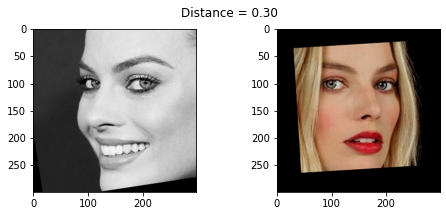

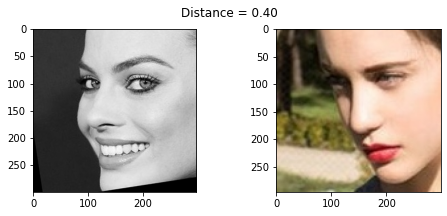

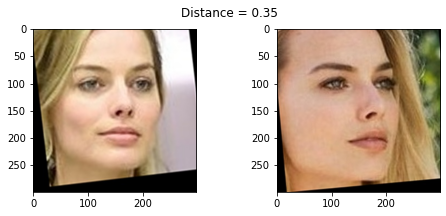

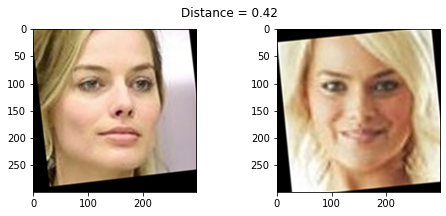

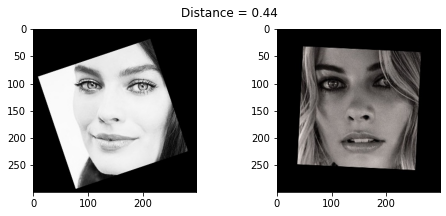

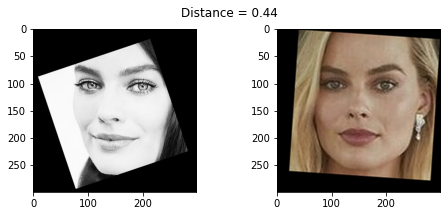

In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

#### Create train and test sets [ Score: 2 points ]
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

#### Add your code here ####

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

#### Encode the Labels  [ Score: 2 points ]
- Encode the targets
- Use LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_label=label_encoder.fit_transform(y_train) 
y_test_label=label_encoder.fit_transform(y_test) 

#### Standardize the feature values [ Score: 2 points ]
- Scale the features using StandardScaler

In [ ]:
# Standarize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_S=scaler.fit_transform(X_train)
X_test_S = scaler.transform(X_test)
#### Add your code here ####

#### Reduce dimensions using PCA (3 marks)
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [ ]:
from sklearn.decomposition import PCA
n = 128
pca = PCA(n_components=n)
X_train_S_pca = pca.fit_transform(X_train_S)
X_test_S_pca = pca.transform(X_test_S)
#### Add your code here ####

In [ ]:
X_train_S_pca.shape

(1045, 128)

#### Build a Classifier (3 marks)
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:
from sklearn.svm import SVC
svc_classifier = SVC()
svc_classifier.fit(X_train_S_pca, y_train_label)
svc_train_accuracy=svc_classifier.score(X_train_S_pca, y_train_label)
svc_test_accuracy=svc_classifier.score(X_test_S_pca, y_test_label)


In [ ]:
svc_y_pred=svc_classifier.predict(X_test_S_pca)
#svc_f1 = (f1_score(y_test_label,svc_y_pred, average='micro')*100)
print ('Train Accuracy',svc_train_accuracy )
print ('Test Accuracy', svc_test_accuracy)

Train Accuracy 0.9960305024548208
Test Accuracy 0.9657477025898078


#### Test results (2 marks)
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

PINS/pins_margot robbie face/margot robbie face16.jpg


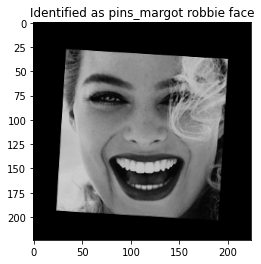

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_image = (example_image / 255.).astype(np.float32)
example_image = cv2.resize(example_image, (224, 224))
embedding = vgg_face_descriptor.predict(np.expand_dims(example_image, axis = 0))[0]
embedding_scaled = scaler.transform(embedding.reshape(1, -1))

example_prediction = svc_classifier.predict(pca.transform(embedding_scaled))
example_identity = label_encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

Task here was to recognize (aligned) faces from a dataset containing 10k+ images for 100 people using a pre-trained model on Face Recognition.

VGG model with pre-trained weights was used to generate embeddings for each images in the dataset.
Distance between two pair of images were also calculated and plotted.
Since, there were 2,622 features for each image, PCA was used for dimension reduction after standardizing the features.
Using SVC we predicted the labels for test dataset with an accuracy of more than 97%.
Also the image to be predicted is **pins_maria pedraza** and is **predicted correctly**